In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from geopy import Nominatim as nom
import re, math

In [ ]:
df = pd.read_csv('/content/raw_house_data.csv')
df = df.drop_duplicates()
df.shape

(5000, 16)

# Funcs

In [ ]:
def charts(frame, col, cut_off):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    ax1.hist(df[col])
    sns.boxplot(x=df[col], ax=ax2)

    ax3.hist(df[df[col]<=cut_off][col])
    sns.boxplot(x=df[df[col]<=cut_off][col], ax=ax4)

def scatters(df, target):
    cols = df.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(8, len(cols)*6), gridspec_kw={'hspace' : 0.3})

    for i, col in enumerate(cols):
        axes[i].plot(df[col], df[target], 'o')
        axes[i].set_xlabel(col, fontsize=14)
        axes[i].set_ylabel(target, fontsize=14)
        axes[i].set_title(f"{target} vs {col}", fontsize=18)

# Dealing with missing values

In [ ]:
# Convert all 'None' values to nan
cols = ['MLS', 'sold_price', 'zipcode', 'lot_acres', 'taxes', 'year_built',
       'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 'kitchen_features',
       'fireplaces', 'floor_covering', 'HOA']
for i in cols:
  df[i].replace('None', np.nan, inplace=True)

Text(0.5, 0, 'Number of Missing values')

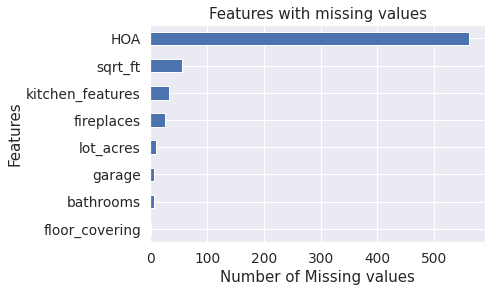

In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.barh()
plt.title("Features with missing values")
plt.ylabel("Features")
plt.xlabel("Number of Missing values")

In [ ]:
df.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

In [ ]:
df.isnull().sum().sum()

700

ASSUMPTION: I am assuming nan values for ['HOA', 'fireplaces', 'garage'] denotes that the property doesnt have the corresponding item. I am therefore converting those nan values to 0 to represent my assumption. 

In [ ]:
# With that assumption, I will change those nan values to 0
cols_nan_to_0 = ['HOA', 'fireplaces', 'garage', 'lot_acres']
for i in cols_nan_to_0:
  df[i].replace(np.nan, 0, inplace=True)

In [ ]:
# With that assumption, I will change those nan values to None
cols_nan_to_none = ['kitchen_features', 'floor_covering']
for i in cols_nan_to_none:
  df[i].replace(np.nan, None, inplace=True)

In [ ]:
df.isnull().sum()

MLS                  0
sold_price           0
zipcode              0
longitude            0
latitude             0
lot_acres            0
taxes                0
year_built           0
bedrooms             0
bathrooms            6
sqrt_ft             56
garage               0
kitchen_features     0
fireplaces           0
floor_covering       0
HOA                  0
dtype: int64

In [ ]:
(df.isnull().sum().sum())/5000

0.0124

Only 2% of the data contains missing values at this point. Being that it is less than 5% of the total data, I think it is safe to remove them. 

In [ ]:
df = df.dropna()
df.shape

(4944, 16)

In [ ]:
df.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

In [ ]:
# Converting the object types to a numerical type
df.bathrooms = df.bathrooms.astype(float)
df.sqrt_ft = df.sqrt_ft.astype(float)
df.garage = df.garage.astype(float).astype(int)
df.fireplaces = df.fireplaces.astype(int)
df.HOA = df.HOA.replace(',','', regex=True)
df.HOA = df.HOA.astype(float)
df.dtypes

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms           float64
sqrt_ft             float64
garage                int64
kitchen_features     object
fireplaces            int64
floor_covering       object
HOA                 float64
dtype: object

Now that the dtypes have been dealth with I will create another dataframe to start cleaning another aspect of the data.

In [ ]:
# kitchen_items = set([])
# for i in df2['kitchen_features'].unique():
#   for item in i.split(','):
#     kitchen_items.add(item.strip(' '))
# kitchen_items = sorted(kitchen_items)
# for i in kitchen_items:
#   print(i)

After seeing how dirty the 'kitchen_features' data is I decided to remove it until further notice. I think it can be processed and added to the dataset using a one-hot-encoding style in the future, but until I develope a method for doing so I believe it is better to leave it out of the dataset. 

In [ ]:
# df3 = df2.drop(['kitchen_features'], axis=1)
# print(df3.shape)
# df3.head(3)

In [ ]:
# floor_items = set([])
# for i in df3['floor_covering'].unique():
#   for item in i.split(','):
#     floor_items.add(item.strip(' '))
# floor_items = sorted(floor_items)
# for i in floor_items:
#   print(i)

I am removing floor_coverings for the same reason I removed kitchen_items

In [ ]:
# df3 = df3.drop(['floor_covering'], axis=1)
# print(df3.shape)
# df3.head(3)

I believe the important information in the HOA column is whether a property does or doesn't have an attached HOA, so I one-hot-encoded the HOA column to represent that. I think this is a better representation because some area's will naturally have a higher population, thus a larger HOA, and that could skew the results.

In [ ]:
df.HOA = df.HOA.apply(lambda x: 1 if x > 0.0 else 0)
df.HOA.unique()

array([0, 1])

I am creating two columns ['price_per_sqft', 'price_per_acre'] because I believe they will be good price estimators. Before I can do that I will check & remove rows where either of those columns are 0 as long as I don't end up removing more than 5% of the original data. 

In [ ]:
print(df[df['sqrt_ft'].apply(lambda x: x == 0.0)].shape)

(0, 16)


In [ ]:
df = df[~df['sqrt_ft'].apply(lambda x: x == 0.0)]

Since it was only 35 rows I know I can remove them without going over my 5% limit. In total, I removed a little less than 3% of the data. 

In [ ]:
# df['pp_sqft'] = round(df['sold_price']/df['sqrt_ft'], 2)
df = df.drop("MLS", axis=1)
df.head()

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.0,0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0
1,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.0,0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0
3,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",0
4,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.0,3,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",1
5,3250000.0,85718,-110.910593,32.339090,1.67,27802.84,1999,3,4.0,6842.0,3,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Natural Stone, Wood, Other",1


# Cleaning

## Removing Outliers

In [ ]:
df = df.drop(df[df.sold_price == 0].index)
df.shape

(4944, 15)

In [ ]:
numeric_cols = df.describe(include=[np.number]).columns
obj_cols = df.describe(exclude=[np.number]).columns

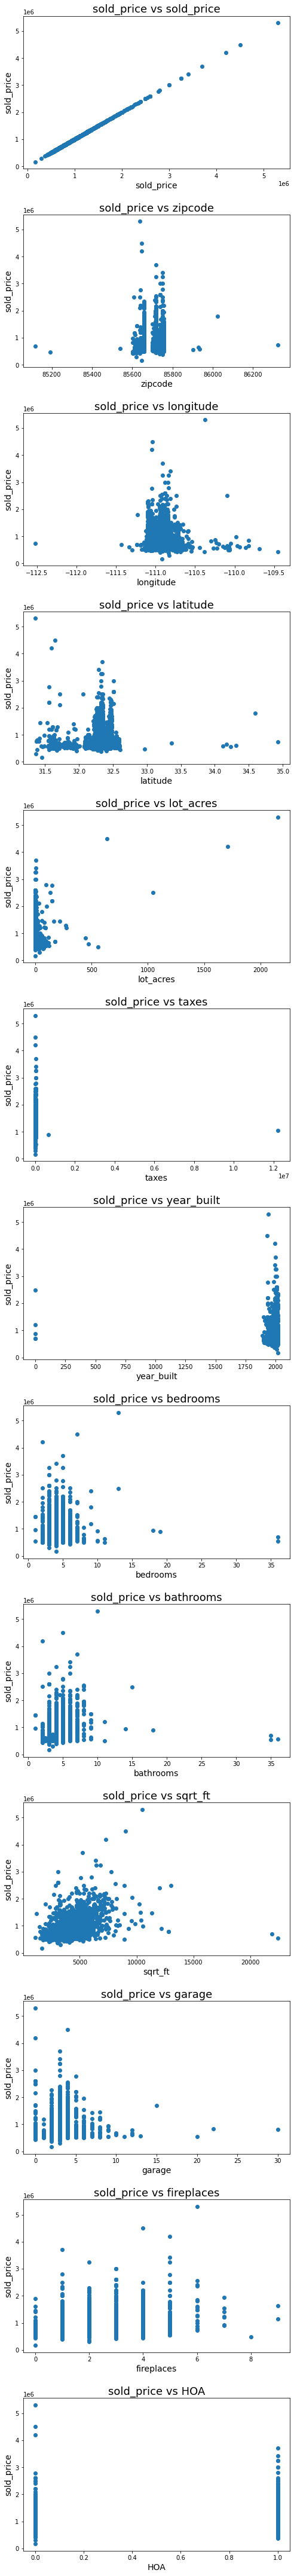

In [ ]:
test_df = pd.concat([df[x] for x in numeric_cols], axis=1)
scatters(test_df, "sold_price")

In [ ]:
# 'Outliers' removed after glancing at the scatter plots
df = df[df.lot_acres < 1000]
df = df[df.taxes < 600000]
df = df[df.year_built != 0]
df = df[df.bedrooms < 15]
df = df[df.bathrooms < 20]
df = df[df.sqrt_ft < 15000]
df = df[df.garage < 15]
# df = df[df.sold_price > 3000000]

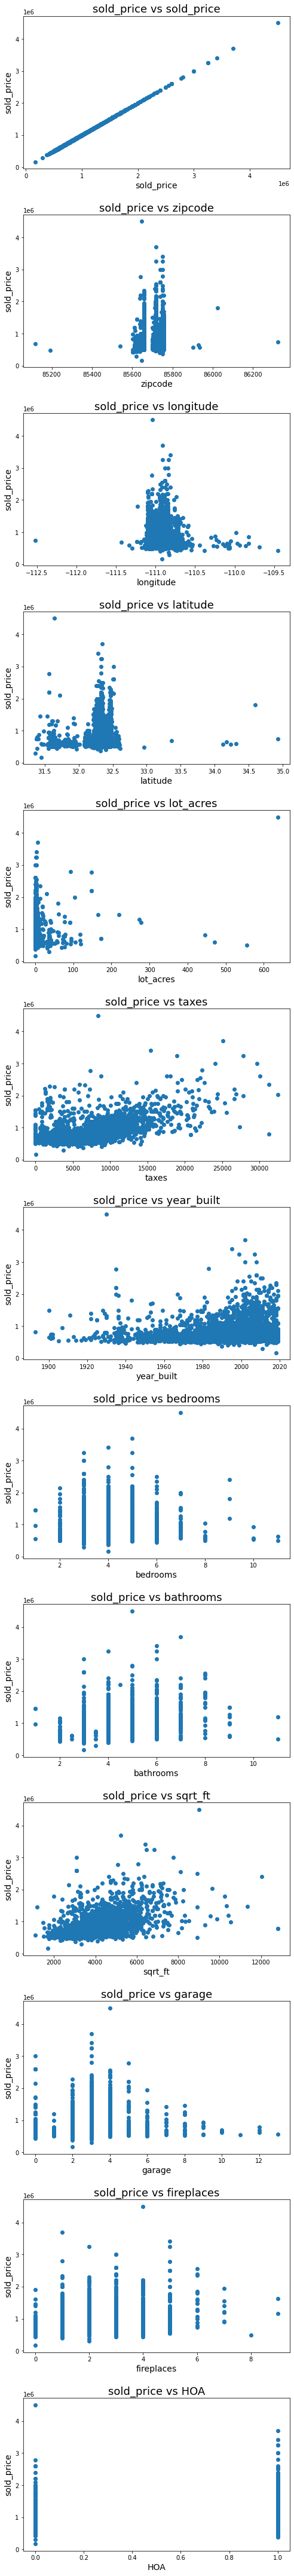

In [ ]:
test_df = pd.concat([df[x] for x in numeric_cols], axis=1)
scatters(test_df, "sold_price")

In [ ]:
df.shape

(4925, 15)

# Exploring each feature

## Zipcode

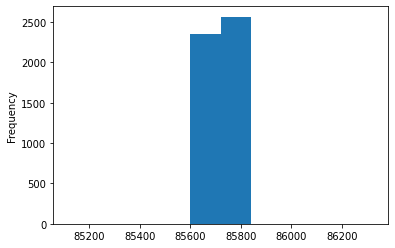

In [ ]:
df.zipcode.plot(kind="hist")

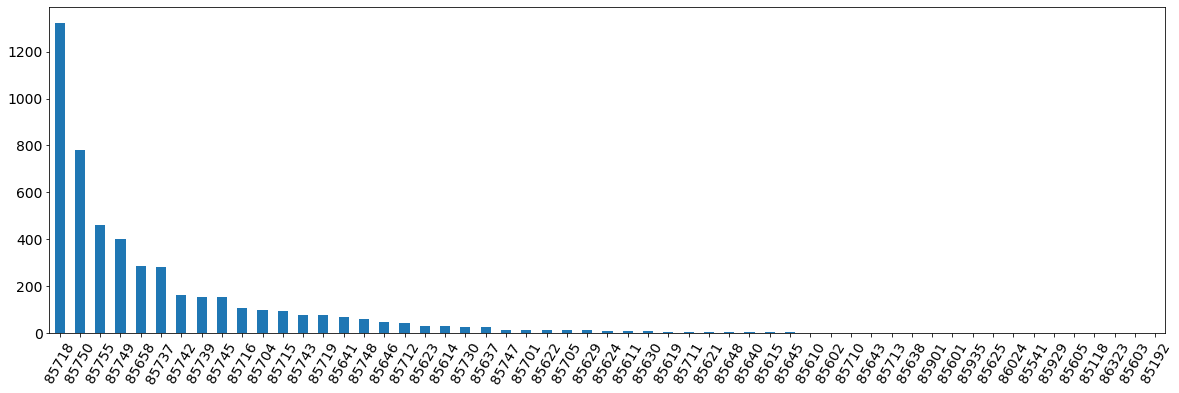

In [ ]:
zips = df.zipcode.value_counts()
zips.plot(kind="bar", figsize=(20,6), rot=60, fontsize=14)

In [ ]:
cutoff = 5
print(zips[zips < cutoff].sum())
print(zips[zips < cutoff])

32
85640    4
85615    3
85645    3
85610    2
85602    2
85710    2
85643    2
85713    1
85638    1
85901    1
85601    1
85935    1
85625    1
86024    1
85541    1
85929    1
85605    1
85118    1
86323    1
85603    1
85192    1
Name: zipcode, dtype: int64


[]

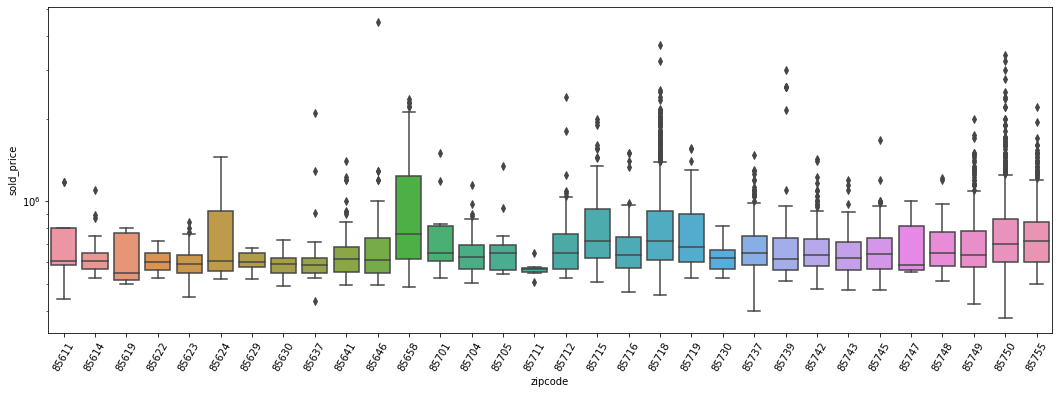

In [ ]:
zipcode_df = pd.concat([df["sold_price"], df["zipcode"]], axis=1)

# Selecting only the zip-codes that contain houses > 25
zipcode_select = zipcode_df.groupby('zipcode').filter(lambda x: len(x) > 5)

f, ax = plt.subplots(figsize=(18, 6))
ax.set_yscale("log") # making logarithmic y-axis (sold_price)
fig = sns.boxplot(x="zipcode", y="sold_price", data=zipcode_select)
fig.set_xticklabels(fig.get_xticklabels(), rotation=60)
fig.plot()

## Longitude

Text(0.5, 1.0, 'sold_price vs longitude')

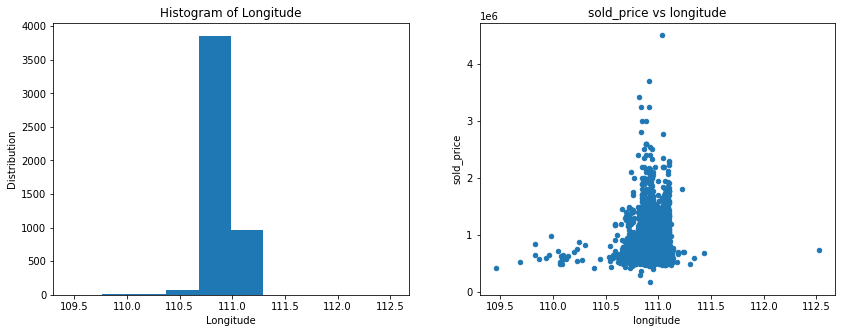

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of longitude
df.loc[:, "longitude"] = df['longitude'].abs()
df["longitude"].plot(kind='hist', ax=ax1)
ax1.set_title("Histogram of Longitude")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Distribution")

# sold_price vs longitude:
lon_df = pd.concat([df['sold_price'], df['longitude']], axis=1)
fig1 = lon_df.plot.scatter(x='longitude', y='sold_price', ax=ax2)
ax2.set_title('sold_price vs longitude')

## Latitude

Text(0.5, 1.0, 'sold_price vs latitude')

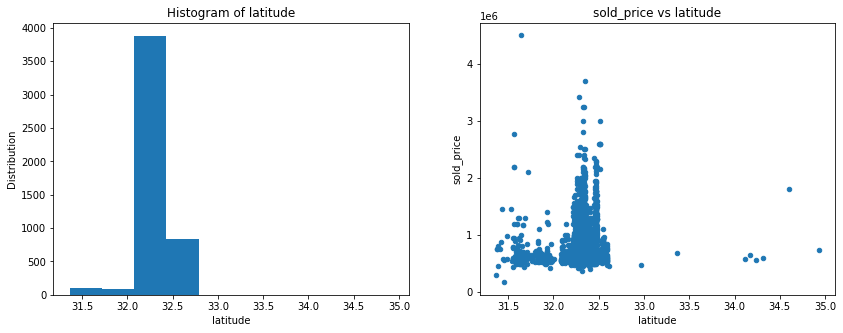

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df.loc[:, "latitude"] = df['latitude'].abs()
df["latitude"].plot(kind='hist', ax=ax1)
ax1.set_title("Histogram of latitude")
ax1.set_xlabel("latitude")
ax1.set_ylabel("Distribution")

# Scatter:
lon_df = pd.concat([df['sold_price'], df['latitude']], axis=1)
fig1 = lon_df.plot.scatter(x='latitude', y='sold_price', ax=ax2)
ax2.set_title('sold_price vs latitude')

## Lot_acres

Text(0.5, 1.0, 'sold_price vs lot_acres')

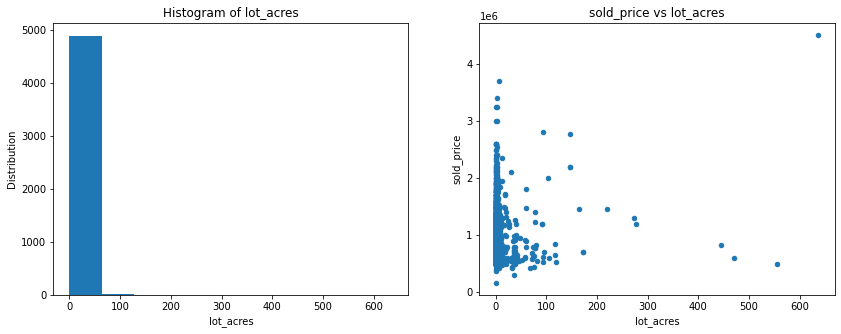

In [ ]:
acres_df = pd.concat([df["sold_price"], df["lot_acres"]], axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
acres_df.lot_acres.plot(kind='hist', ax=ax1)
ax1.set_title("Histogram of lot_acres")
ax1.set_xlabel("lot_acres")
ax1.set_ylabel("Distribution")

# Scatter:
fig1 = acres_df.plot.scatter(x='lot_acres', y='sold_price', ax=ax2)
ax2.set_title('sold_price vs lot_acres')

## Taxes

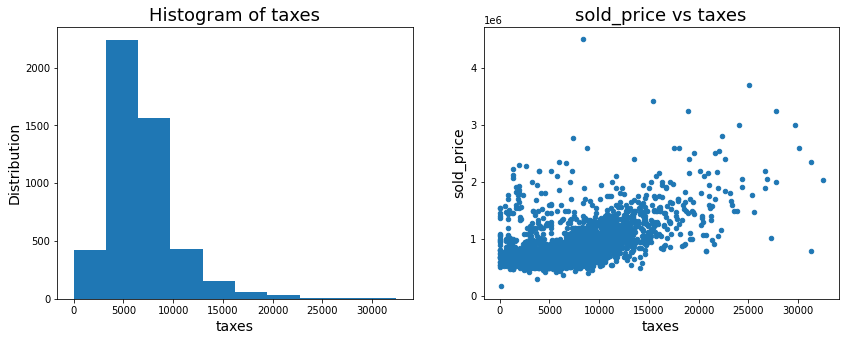

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df["taxes"].plot(kind='hist', ax=axes[0])
axes[0].set_title("Histogram of taxes", fontsize=18)
axes[0].set_xlabel("taxes", fontsize=14)
axes[0].set_ylabel("Distribution", fontsize=14)

# Scatter
lon_df = pd.concat([df['sold_price'], df['taxes']], axis=1)
lon_df.plot.scatter(x='taxes', y='sold_price', ax=axes[1])
axes[1].set_title('sold_price vs taxes', fontsize=18)
axes[1].set_xlabel("taxes", fontsize=14)
axes[1].set_ylabel("sold_price", fontsize=14)
print()

## Year_built

[]

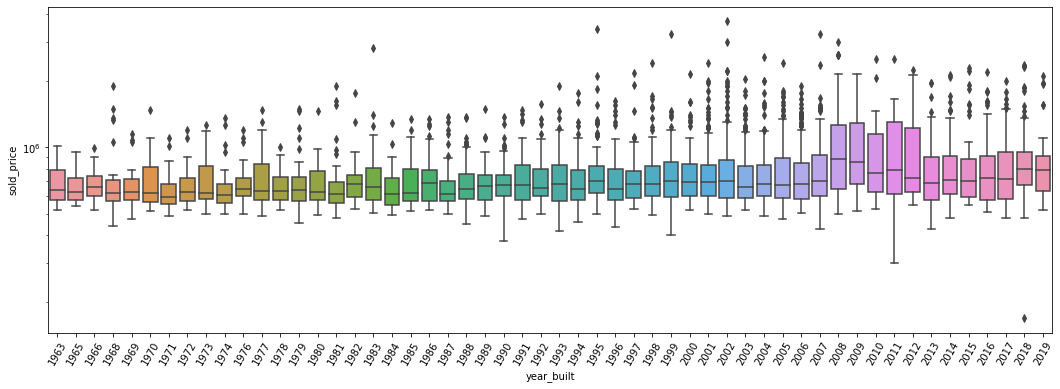

In [ ]:
year_df = pd.concat([df["sold_price"], df["year_built"]], axis=1)
years_selected = year_df.groupby('year_built').filter(lambda x: len(x) > 20)

f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x="year_built", y="sold_price", data=years_selected, ax=ax)
ax.set_xticklabels(fig.get_xticklabels(), rotation=60)
ax.set_yscale("log") # making logarithmic y-axis (sold_price)
ax.plot()

In [ ]:
years = year_df.year_built.value_counts()
print(len(years.unique()))

65


## Bedrooms

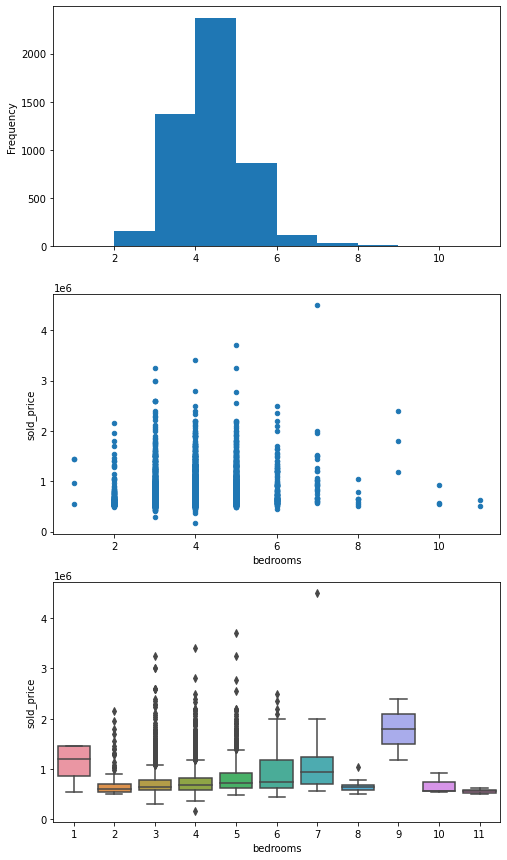

In [ ]:
beds_df = pd.concat([df["sold_price"], df["bedrooms"]], axis=1)
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Histogram
beds_df.bedrooms.plot(kind='hist', ax=axes[0])
ax1.set_title("Histogram of Bedrooms")
ax1.set_xlabel("Bedrooms")
ax1.set_ylabel("Distribution")

# Scatter
beds_df.plot.scatter(x='bedrooms', y='sold_price', ax=axes[1])
ax2.set_title('sold_price vs Bedrooms')

# Boxplot
bp = sns.boxplot(x='bedrooms', y="sold_price", data=beds_df, ax=axes[2])

## Bathrooms

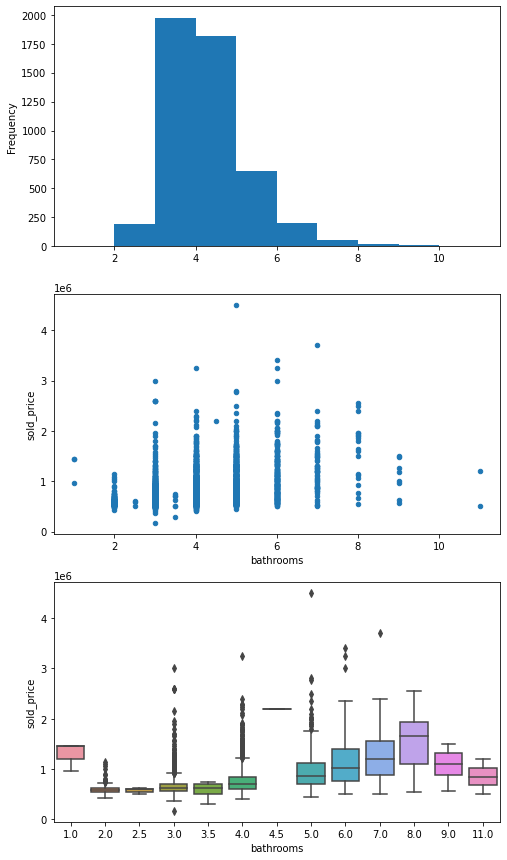

In [ ]:
bath_df = pd.concat([df["sold_price"], df["bathrooms"]], axis=1)
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

bath_df = bath_df[bath_df.bathrooms < 15]

# Histogram
bath_df.bathrooms.plot(kind='hist', ax=axes[0])
ax1.set_title("Histogram of Bathrooms")
ax1.set_xlabel("Bathrooms")
ax1.set_ylabel("Distribution")

# Scatter:
bath_df.plot.scatter(x='bathrooms', y='sold_price', ax=axes[1])
ax2.set_title('sold_price vs Bathrooms')

# Boxplot
bp = sns.boxplot(x='bathrooms', y="sold_price", data=bath_df, ax=axes[2])

## sqrt_ft

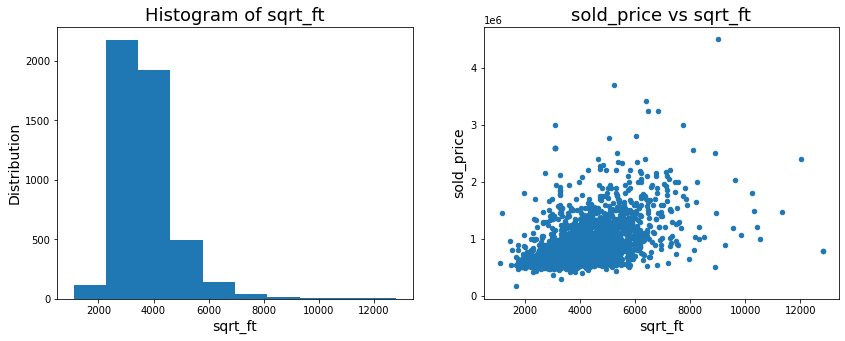

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df["sqrt_ft"].plot(kind='hist', ax=axes[0])
axes[0].set_title("Histogram of sqrt_ft", fontsize=18)
axes[0].set_xlabel("sqrt_ft", fontsize=14)
axes[0].set_ylabel("Distribution", fontsize=14)

# Scatter
lon_df = pd.concat([df['sold_price'], df['sqrt_ft']], axis=1)
lon_df.plot.scatter(x='sqrt_ft', y='sold_price', ax=axes[1])
axes[1].set_title('sold_price vs sqrt_ft', fontsize=18)
axes[1].set_xlabel("sqrt_ft", fontsize=14)
axes[1].set_ylabel("sold_price", fontsize=14)
print()

## Garage

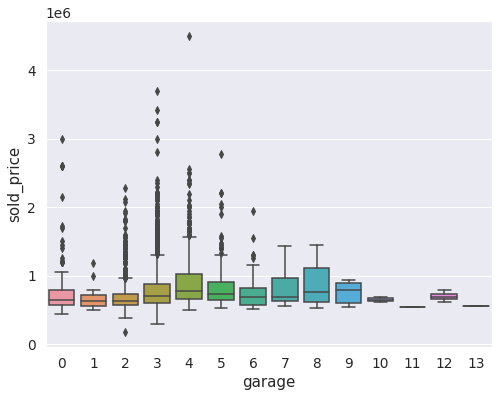

In [ ]:
garage_df = pd.concat([df['sold_price'], df['garage']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='garage', y="sold_price", data=garage_df, ax=ax)
# ax.set_yscale("log")

## Kitchen_features

## Fireplaces

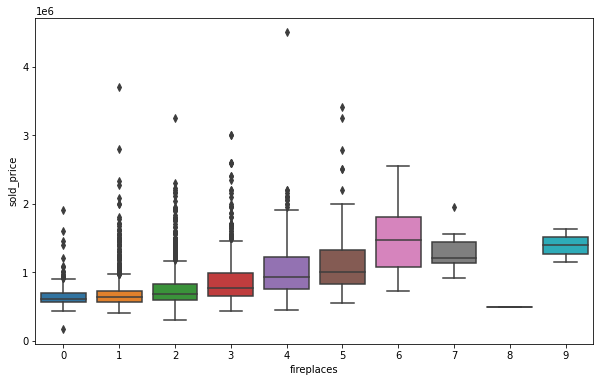

In [ ]:
fireplace_df = pd.concat([df['sold_price'], df['fireplaces']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='fireplaces', y="sold_price", data=fireplace_df, ax=ax)

## Floor_covering

## HOA

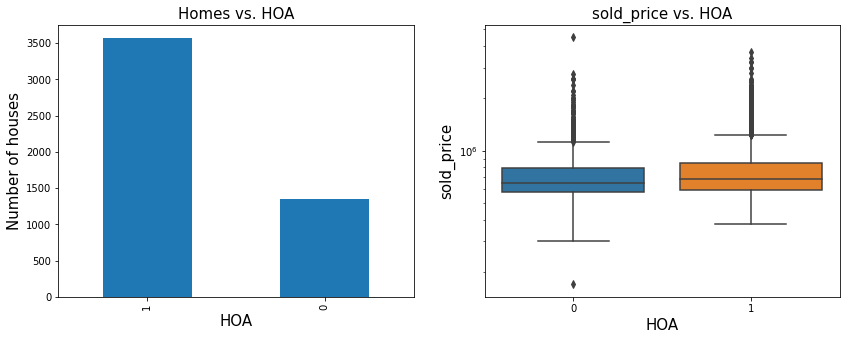

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of 'Number of houses' vs 'basements':
hoa_vals = df.HOA.value_counts()
hoa_vals.plot.bar(ax=ax1)
ax1.set_title("Homes vs. HOA", fontsize=15)
ax1.set_xlabel("HOA", fontsize = 15)
ax1.set_ylabel("Number of houses", fontsize = 15)

# Box plot 'hoa' vs. 'sold_price'
ac_df = pd.concat([df['sold_price'], df['HOA']], axis=1)
sns.boxplot(x='HOA', y="sold_price", data=ac_df, ax=ax2)
ax2.set_title("sold_price vs. HOA", fontsize=15)
ax2.set_xlabel("HOA", fontsize=15)
ax2.set_ylabel("sold_price", fontsize=15)
ax2.set_yscale("log")

# Saving the dataset

# Feature Engineering

## New features

In [ ]:
df["avg_room_size"] = (df["sqrt_ft"]//(df.bedrooms + df.bathrooms)).astype(int)
df["home_age"] = (2022 - df.year_built)
df["bed_bath"] = (df.bedrooms * df.bathrooms).astype(int)

## Correlations

In [ ]:
corr = df.corr()
corr.sort_values(["sold_price"], ascending=False, inplace=True)
corr.sold_price

sold_price       1.000000
taxes            0.585156
sqrt_ft          0.563904
bathrooms        0.458691
fireplaces       0.382040
avg_room_size    0.351464
bed_bath         0.348381
bedrooms         0.144607
lot_acres        0.139731
garage           0.134189
year_built       0.113012
HOA              0.069201
latitude         0.061837
longitude        0.061368
zipcode         -0.037835
home_age        -0.113012
Name: sold_price, dtype: float64

Text(0.5, 1.0, 'Feature Heatmap')

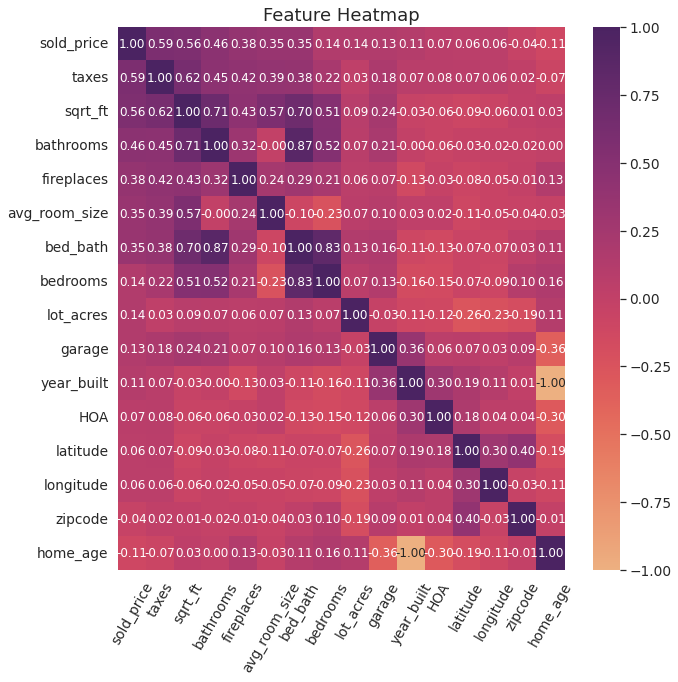

In [ ]:
corrmat = df.corr()
cols = corrmat.nlargest(len(df.columns), 'sold_price')['sold_price'].index
cm = np.corrcoef(df[cols].values.T)

# Seaborn Heatmap
sns.set(font='sans-serif', font_scale=1.25)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 12}, cmap="flare")
hm.set_yticklabels(cols.values, rotation=0)
hm.set_xticklabels(cols.values, rotation=60)
hm.set_title("Feature Heatmap", fontsize=18)